# ISM 645-Final Project-Predicting 12-month conversion risk (NC/MCI/AD)
## Name: John Daly
## Course: ISM645-Fall 2025
## Instructor: Dr. Shimi Zhou

In [1]:
#Configuration and import libraries
import os, math, json, warnings, datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, average_precision_score, f1_score, accuracy_score, 
                             brier_score_loss, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

DATA_FILE = Path("C:/Users/jdaly/OneDrive/Desktop/ISM645-Pred Analytics/TADPOLE/TADPOLE_D1_D2.csv")
FIG_DIR = Path("C:/Users/jdaly/OneDrive/Desktop/ISM645-Pred Analytics/TADPOLE/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)
RNG_SEED = 42
np.random.seed(RNG_SEED)

print("Figures will be save to:", FIG_DIR.resolve())

Figures will be save to: C:\Users\jdaly\OneDrive\Desktop\ISM645-Pred Analytics\TADPOLE\figures


## About the TADPOLE Datasets (D1–D3)

TADPOLE defines four standardized datasets derived from the Alzheimer’s Disease Neuroimaging Initiative (ADNI):

| Dataset | Description | Typical Use | Key Trait |
|----------|--------------|--------------|------------|
| **D1** | Historical ADNI training data | Model development | Broad coverage, older data |
| **D2** | Longitudinal prediction set (many visits per subject) | Forecasting progression over time | Rich temporal structure |
| **D3** | Cross-sectional prediction set (single, most recent visit per subject) | Baseline risk prediction | Real-world snapshot scenario |

**Rationale for this approach:**  
D3 represents a baseline snapshot, mirroring real clinical trial conditions where only one visit is available per participant.  
However, the D1_D2 dataset offers a more comprehensive longitudinal record that allows custom label creation — such as the 12-month conversion target used here.  
Using D1_D2 ensures:
- Access to richer historical information,
- The ability to construct outcome labels consistently,
- Flexibility to later derive a D3-style baseline subset if desired.

This approach balances data richness (from D2) with practical interpretability (as in D3).

In [2]:
#Load the TADPOLE data
if not DATA_FILE.exists():
    raise FileNotFoundError(
        f"TADPOLE file not found at {DATA_FILE}. "
        "Please confirm the path and filename of TADPOLE_D1_D2.csv")
    
df_all = pd.read_csv(DATA_FILE)

#Normalizing a few common column names and dtypes
rename_map = {'PTGENDER': 'SEX', 'PTGENDER.x': 'SEX'}
df_all = df_all.rename(columns=rename_map)

if 'EXAMDATE' not in df_all.columns:
    raise KeyError("Expected column 'EXAMDATE' was not found. Please verify the TADPOLE schema.")
df_all['EXAMDATE'] = pd.to_datetime(df_all['EXAMDATE'], errors='coerce')

if 'DX' not in df_all.columns:
    raise KeyError("Expected column 'DX' not found. Please verify the TADPOLE schema.")
    
print("Loaded rows:", len(df_all))
df_all.head()

Loaded rows: 12741


,RID,PTID,VISCODE,SITE,D1,D2,COLPROT,ORIGPROT,EXAMDATE,DX_bl,...,PHASE_UPENNBIOMK9_04_19_17,BATCH_UPENNBIOMK9_04_19_17,KIT_UPENNBIOMK9_04_19_17,STDS_UPENNBIOMK9_04_19_17,RUNDATE_UPENNBIOMK9_04_19_17,ABETA_UPENNBIOMK9_04_19_17,TAU_UPENNBIOMK9_04_19_17,PTAU_UPENNBIOMK9_04_19_17,COMMENT_UPENNBIOMK9_04_19_17,update_stamp_UPENNBIOMK9_04_19_17
0,2,011_S_0002,bl,11,1,1,ADNI1,ADNI1,2005-09-08,CN,...,,,,,,,,,,
1,3,011_S_0003,bl,11,1,0,ADNI1,ADNI1,2005-09-12,AD,...,ADNI1,UPENNBIOMK9,P06-MP02-MP01,P06-MP02-MP01/2,2016-12-14,741.5,239.7,22.83,NaN,2017-04-20 14:39:54.0
2,3,011_S_0003,m06,11,1,0,ADNI1,ADNI1,2006-03-13,AD,...,,,,,,,,,,
3,3,011_S_0003,m12,11,1,0,ADNI1,ADNI1,2006-09-12,AD,...,ADNI1,UPENNBIOMK9,P06-MP02-MP01,P06-MP02-MP01/2,2016-12-14,601.4,251.7,24.18,NaN,2017-04-20 14:39:54.0
4,3,011_S_0003,m24,11,1,0,ADNI1,ADNI1,2007-09-12,AD,...,,,,,,,,,,


## Introduction, Motivation, and Dataset

### Introduction
Alzheimer’s disease (AD) is a progressive neurodegenerative disorder and the leading cause of dementia worldwide, currently affecting over **55 million people**. It gradually erodes memory, reasoning, and independence, placing an enormous emotional and economic burden on patients, caregivers, and healthcare systems.  
Predictive analytics offers a data-driven approach to understanding and forecasting Alzheimer’s progression, allowing earlier interventions, improved care planning, and potentially reduced long-term costs.

### Motivation
**Personal Motivation:**  
This research carries deep personal significance — Alzheimer’s has affected my own family, heightening my awareness of its devastating impact and fueling my interest in solutions that blend empathy with data-driven insight.  

**Professional Motivation:**  
As an engineer drawn to complex, data-rich problems, I find Alzheimer’s research a compelling domain where analytical modeling can truly make a difference. Predictive modeling provides an opportunity to apply machine learning and statistical methods to improve early detection and guide medical decision-making.

**Humanitarian and Economic Rationale:**  
- *Humanitarian Impact:* Early identification of at-risk individuals can preserve quality of life, reduce caregiver strain, and enable personalized treatment strategies.  
- *Economic Impact:* Alzheimer’s disease costs the U.S. over **$300 billion annually**. Predictive models can help optimize healthcare resources by forecasting patient needs and disease trajectories.

### Dataset Overview – The TADPOLE Challenge
The **TADPOLE (The Alzheimer’s Disease Prediction Of Longitudinal Evolution)** dataset was derived from the **Alzheimer’s Disease Neuroimaging Initiative (ADNI)** and designed for forecasting Alzheimer’s progression. It combines:
- **Demographic data:** age, sex, education, and APOE4 genetic status  
- **Clinical data:** baseline and follow-up diagnoses (CN, MCI, AD)  
- **Cognitive scores:** e.g., ADAS-Cog13, MMSE, FAQ  
- **Imaging biomarkers:** hippocampal and ventricular volumes, intracranial volume (ICV)  
- **Molecular biomarkers:** amyloid (AV45), tau, and p-tau levels  

The dataset tracks **thousands of participants** across multiple visits over several years, forming one of the most comprehensive longitudinal resources for modeling Alzheimer’s progression.  

### Why 12-Month Conversion Prediction?
Predicting **12-month conversion from Mild Cognitive Impairment (MCI) to Alzheimer’s Disease (AD)** is a clinically significant task:
- It mirrors the **short-term clinical trial horizon**, where one-year outcomes inform treatment efficacy.  
- It allows physicians and researchers to identify high-risk individuals early, prioritizing those most likely to progress for closer monitoring or therapeutic intervention.  
- It aligns with the TADPOLE challenge’s broader goal — using multimodal longitudinal data to predict disease progression.

In [3]:
#Data prep and cleaning - Baseline and Labelling

#Defining baseline (earliest CN/MCI) and create a 12-month conversion label
#CN (cognitive normal)--MCI (mild cognitive decline)--AD (Alzheimer's Disease)
def define_baseline(df):
    dfc = df.dropna(subset=["EXAMDATE", "DX"]).copy() #DX is diagnosis
    dfc = dfc.sort_values(["RID", "EXAMDATE"]) #RID is research ID number
    mask_nc_mci = dfc["DX"].isin(["CN", "MCI", "NL", "MCIc", "MCIu", "EMCI", "LMCI"])
    base = (dfc[mask_nc_mci].groupby("RID", as_index=False).first())
    base = base.rename(columns={c: f"BASE_{c}" for c in base.columns if c not in ["RID"]})
    return dfc, base 

def first_ad_date(dfg):
    ad = dfg[dfg["DX"] == "AD"]
    if ad.empty:
        return pd.NaT
    return ad["EXAMDATE"].min() 
                                
def make_label(df_sorted, base):
    ad_dates = df_sorted.groupby("RID").apply(first_ad_date)
    ad_dates = ad_dates.rename("FIRST_AD_DATE").reset_index()
    B = base.merge(ad_dates, on="RID", how="left")
    B["convert_within_12m"] = (
        (B["FIRST_AD_DATE"].notna()) &
        ((B["FIRST_AD_DATE"] - B["BASE_EXAMDATE"]).dt.days.between(0, 365, inclusive="both"))
    ).astype(int)
    return B

df_sorted, df_base = define_baseline(df_all)
B = make_label(df_sorted, df_base)

keep_cols = ["RID", "BASE_EXAMDATE", "convert_within_12m", "BASE_DX", "BASE_AGE", "BASE_SEX", "BASE_APOE4",
             "BASE_AV45", "BASE_TAU", "BASE_PTAU", "BASE_Hippocampus", "BASE_ADAS13"]
for c in keep_cols:
    if c not in B.columns:
        B[c] = np.nan
        
df_baseline = B[keep_cols].copy()
print("Baseline subjects:", len(df_baseline))
df_baseline.head()

Baseline subjects: 1392


,RID,BASE_EXAMDATE,convert_within_12m,BASE_DX,BASE_AGE,BASE_SEX,BASE_APOE4,BASE_AV45,BASE_TAU,BASE_PTAU,BASE_Hippocampus,BASE_ADAS13
0,2,2005-09-08,0,NL,74.3,Male,0.0,NaN,NaN,NaN,8336.0,18.67
1,4,2005-11-08,0,MCI,67.5,Male,0.0,NaN,NaN,NaN,6869.0,21.33
2,5,2005-09-07,0,NL,73.7,Male,0.0,NaN,NaN,NaN,7075.0,14.67
3,6,2005-11-29,0,MCI,80.4,Female,0.0,NaN,NaN,NaN,5348.0,25.67
4,8,2005-09-19,0,NL,84.5,Female,0.0,NaN,NaN,NaN,6080.0,7.00


In [4]:
#EDA (Exploratory Data Analysis)

def missing_summary(df):
    total = df.shape[0]
    ms = df.isnull().sum().sort_values(ascending=False)
    pct = (ms / total * 100).round(3)
    out = pd.DataFrame({"missing": ms, "percent": pct})
    return out[out["missing"] > 0]

categorical_cols = [c for c in ["BASE_SEX", "BASE_DX"] if c in df_baseline.columns]
numeric_cols = [c for c in df_baseline.columns if c.startswith("BASE_") and c not in categorical_cols
                and c not in ["BASE_EXAMDATE", "convert_within_12m"]]
target = "convert_within_12m"

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numeric_cols)

Categorical columns: ['BASE_SEX', 'BASE_DX']
Numerical columns: ['BASE_AGE', 'BASE_APOE4', 'BASE_AV45', 'BASE_TAU', 'BASE_PTAU', 'BASE_Hippocampus', 'BASE_ADAS13']


In [5]:
#Precleaning data audit
print("Shape before data cleaning:", df_baseline.shape)
print("\nMissing values before data cleaning (top 25):")
display(missing_summary(df_baseline).head(25))

dup_count = df_baseline.duplicated(subset=["RID"]).sum()
print("Duplicate baseline rows by RID:", dup_count)

df_baseline[numeric_cols].describe().T

Shape before data cleaning: (1392, 12)

Missing values before data cleaning (top 25):


,missing,percent
BASE_TAU,1392,100.000
BASE_PTAU,1392,100.000
BASE_AV45,505,36.279
BASE_Hippocampus,42,3.017
BASE_APOE4,4,0.287


Duplicate baseline rows by RID: 0


,count,mean,std,min,25%,50%,75%,max
BASE_AGE,1392.0,73.484986,6.995406,54.400000,69.000000,73.50000,78.325000,91.40000
BASE_APOE4,1388.0,0.499280,0.634845,0.000000,0.000000,0.00000,1.000000,2.00000
BASE_AV45,887.0,1.169045,0.211563,0.835796,1.007235,1.08685,1.310595,2.02556
BASE_TAU,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BASE_PTAU,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BASE_Hippocampus,1350.0,7001.314815,1110.839765,3281.000000,6232.250000,7078.00000,7748.750000,11068.00000
BASE_ADAS13,1392.0,13.827809,7.009212,0.000000,8.585000,13.00000,18.330000,43.00000


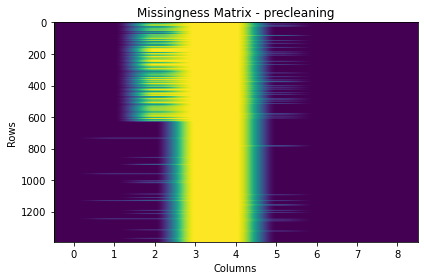

In [7]:
#'Missingness' matrix--a 2D view of missing data 
plt.figure()
miss = df_baseline[numeric_cols + categorical_cols].isnull().astype(int).values
plt.imshow(miss, aspect='auto')
plt.title("Missingness Matrix - precleaning")
plt.xlabel("Columns"); plt.ylabel("Rows")
plt.tight_layout(); plt.savefig(FIG_DIR / "missing_before_clean.png"); plt.show()

Dropping all-NaN numeric features for EDA: ['BASE_TAU', 'BASE_PTAU']
Dropping all-NaN categorical features for EDA: []
Shape after imputation: (1392, 7)
Remaining missing data after imputation (top):


,missing,percent


NOTE: These expected columns are not present post-imputation (likely all-NaN or absent): ['BASE_PTAU', 'BASE_TAU']


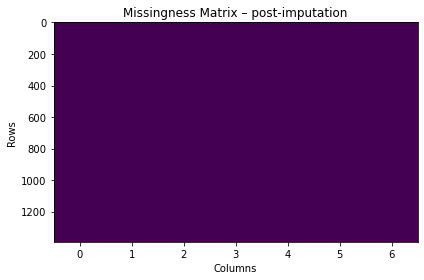

,Dropped (all-NaN),Kept (used),Total considered
Numeric features,2,5,7
Categorical features,0,2,2


,Feature Set,Count,Columns
0,Numeric (Dropped all-NaN),2,• BASE_TAU • BASE_PTAU
1,Categorical (Dropped all-NaN),0,(none)
2,Numeric (Kept),5,• BASE_AGE • BASE_APOE4 • BASE_AV45 • BASE_Hippocampus • BASE_ADAS13
3,Categorical (Kept),2,• BASE_SEX • BASE_DX


Saved tables to: C:\Users\jdaly\OneDrive\Desktop\ISM645-Pred Analytics\TADPOLE\figures\table_a_feature_audit_counts.png and C:\Users\jdaly\OneDrive\Desktop\ISM645-Pred Analytics\TADPOLE\figures\table_b_feature_audit_detailed.png


In [12]:
#EDA Revisted-Imputation
import textwrap

num_imp = SimpleImputer(strategy="median") #median is a better option than mean, as outliers may skew results
cat_imp = SimpleImputer(strategy="most_frequent") #may need to revisit this

#Splitting numeric into usable vs all-NaN (based on CURRENT df_baseline)
num_use = [c for c in numeric_cols if c in df_baseline.columns and df_baseline[c].notna().any()]
num_allnan = [c for c in numeric_cols if c in df_baseline.columns and c not in num_use]
print("Dropping all-NaN numeric features for EDA:", num_allnan)

#Imputing only usable numeric
X_num = num_imp.fit_transform(df_baseline[num_use]) if num_use else np.empty((len(df_baseline), 0))
df_imputed_eda = pd.DataFrame(X_num, columns=num_use, index=df_baseline.index)

#Categorical (same logic)
cat_use, cat_allnan = [], []
if categorical_cols:
    cat_use = [c for c in categorical_cols if c in df_baseline.columns and df_baseline[c].notna().any()]
    cat_allnan = [c for c in categorical_cols if c in df_baseline.columns and c not in cat_use]
    print("Dropping all-NaN categorical features for EDA:", cat_allnan)

    X_cat = cat_imp.fit_transform(df_baseline[cat_use]) if cat_use else np.empty((len(df_baseline),0))
    for i, col in enumerate(cat_use):
        df_imputed_eda[col] = X_cat[:, i]

#Diagnostics
print("Shape after imputation:", df_imputed_eda.shape)
print("Remaining missing data after imputation (top):")
display(missing_summary(df_imputed_eda).head(25))

#Build the column list that ACTUALLY exists now (to avoid KeyError)
cols_after = [c for c in (num_use + cat_use) if c in df_imputed_eda.columns]

#Warning if something expected is missing
expected = set(numeric_cols + categorical_cols)
present = set(df_imputed_eda.columns)
missing_now = sorted(list(expected - present))
if missing_now:
    print("NOTE: These expected columns are not present post-imputation (likely all-NaN or absent):", missing_now)

#Post-imputation "missingness" matrix
plt.figure()
miss_after = df_imputed_eda[cols_after].isnull().astype(int).values
plt.imshow(miss_after, aspect='auto')
plt.title("Missingness Matrix – post-imputation")
plt.xlabel("Columns"); plt.ylabel("Rows")
plt.tight_layout(); plt.savefig(FIG_DIR / "missing_after_impute.png"); plt.show()

#Create easy to read audit tables: summary + detailed and PNG exports

#Summary (counts only)
audit_counts = pd.DataFrame({
    "Dropped (all-NaN)": [len(num_allnan), len(cat_allnan)],
    "Kept (used)": [len(num_use), len(cat_use)],
    "Total considered": [len(num_allnan) + len(num_use), len(cat_allnan) + len(cat_use)]
}, index=["Numeric features", "Categorical features"])

styled_counts = (
    audit_counts.style
        .set_caption("Table A. Feature Audit — Counts")
        .format("{:,.0f}")
        .set_table_styles([
            {"selector": "caption", "props": [("caption-side", "top"), ("font-weight", "bold"), ("padding-bottom", "0.5rem")]},
            {"selector": "th", "props": [("background-color", "#f2f2f2"), ("font-weight", "bold")]}
        ])
)

display(styled_counts)

#Export a DataFrame to a PNG via matplotlib table
def save_table_png(df: pd.DataFrame, path: Path, title: str = "", col_widths=None, font_size=9):
    fig, ax = plt.subplots(figsize=(8, 0.5 + 0.4* (len(df) + 1)))  # dynamic height
    ax.axis('off')
    tbl = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        rowLabels=df.index if df.index.name or (df.index.tolist() != list(range(len(df)))) else None,
        loc='center',
        cellLoc='left',
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(font_size)
    if col_widths:
        for i, w in enumerate(col_widths):
            tbl.auto_set_column_width(i)
    if title:
        ax.set_title(title, fontweight='bold', pad=12)
    fig.tight_layout()
    fig.savefig(path, dpi=200, bbox_inches='tight')
    plt.close(fig)

#Export the summary counts table
save_table_png(
    audit_counts.copy(),
    FIG_DIR / "table_a_feature_audit_counts.png",
    title="Table A. Feature Audit — Counts",
    font_size=10
)

#Detailed (names listed) – with wrapping and line breaks
def _fmt_list(lst):
    if not lst: return "(none)"
    return "• " + "\n• ".join(lst)

audit_detail = pd.DataFrame({
    "Feature Set": ["Numeric (Dropped all-NaN)", "Categorical (Dropped all-NaN)",
                    "Numeric (Kept)", "Categorical (Kept)"],
    "Count": [len(num_allnan), len(cat_allnan), len(num_use), len(cat_use)],
    "Columns": [_fmt_list(num_allnan), _fmt_list(cat_allnan),
                _fmt_list(num_use), _fmt_list(cat_use)]
})

#Display with wrapped text in notebook
styled_detail = (
    audit_detail.style
        .set_caption("Table B. Feature Audit — Detailed Lists")
        .format({"Count": "{:,.0f}"})
        .set_properties(subset=["Columns"], **{"white-space": "pre-wrap"})
        .set_table_styles([
            {"selector": "caption", "props": [("caption-side", "top"), ("font-weight", "bold"), ("padding-bottom", "0.5rem")]},
            {"selector": "th", "props": [("background-color", "#f2f2f2"), ("font-weight", "bold")]},
            {"selector": "td", "props": [("vertical-align", "top")]}
        ])
)
display(styled_detail)

#For PNG export, wrap the text to keep the image compact
def wrap_bullets(text: str, width=40):
    if text == "(none)": return text
    lines = []
    for line in text.split("\n"):
        if line.startswith("• "):
            bullet = "• "
            wrapped = textwrap.wrap(line[2:], width=width) or [""]
            lines.extend([bullet + wrapped[0]] + ["  " + w for w in wrapped[1:]])
        else:
            lines.extend(textwrap.wrap(line, width=width) or [""])
    return "\n".join(lines)

audit_detail_png = audit_detail.copy()
audit_detail_png["Columns"] = audit_detail_png["Columns"].apply(lambda s: wrap_bullets(s, width=40))

#Export the detailed table to PNG
save_table_png(
    audit_detail_png.set_index("Feature Set"),
    FIG_DIR / "table_b_feature_audit_detailed.png",
    title="Table B. Feature Audit — Detailed Lists",
    font_size=9
)

print("Saved tables to:",
      FIG_DIR / "table_a_feature_audit_counts.png",
      "and",
      FIG_DIR / "table_b_feature_audit_detailed.png")

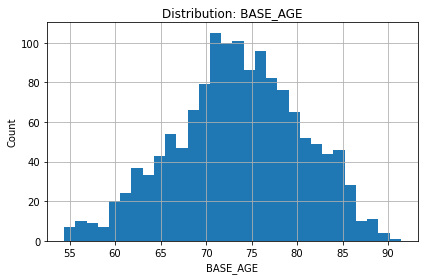

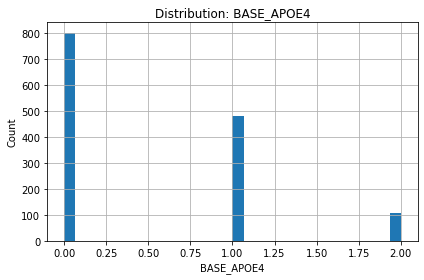

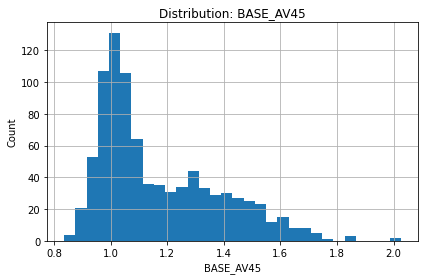

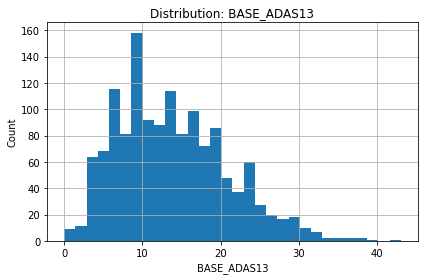

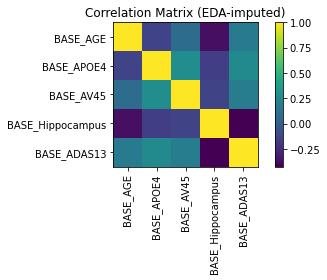

BASE_Hippocampus vs BASE_ADAS13: 0.426
BASE_AGE vs BASE_Hippocampus: 0.365
BASE_APOE4 vs BASE_AV45: 0.273
BASE_APOE4 vs BASE_ADAS13: 0.258
BASE_AV45 vs BASE_ADAS13: 0.180
BASE_APOE4 vs BASE_Hippocampus: 0.160
BASE_AGE vs BASE_ADAS13: 0.156
BASE_AGE vs BASE_APOE4: 0.137
BASE_AV45 vs BASE_Hippocampus: 0.131
BASE_AGE vs BASE_AV45: 0.080


In [18]:
#Look at distributions, correlations, relationships and outliers

#Looking at distributions
for col in ["BASE_AGE","BASE_APOE4","BASE_AV45","BASE_HIPPOCAMPUS","BASE_ADAS13"]:
    if col in df_baseline.columns:
        plt.figure()
        df_baseline[col].hist(bins=30)
        plt.title(f"Distribution: {col}")
        plt.xlabel(col); plt.ylabel("Count")
        plt.tight_layout(); plt.savefig(FIG_DIR / f"hist_{col}.png"); plt.show()
        
#Correlation heatmap of EDA-imputed metrics
num_exist = [c for c in numeric_cols if c in df_imputed_eda.columns]
try:
    corr = df_imputed_eda[num_exist].corr(numeric_only=True)
except TypeError:
    corr = df_imputed_eda[num_exist].corr()
plt.figure()
ax = plt.gca()
im = ax.imshow(corr, interpolation="nearest")
ax.set_xticks(range(len(num_exist))); ax.set_xticklabels(num_exist, rotation=90)
ax.set_yticks(range(len(num_exist))); ax.set_yticklabels(num_exist)
plt.title("Correlation Matrix (EDA-imputed)")
plt.colorbar(im)
plt.tight_layout(); plt.savefig(FIG_DIR / "corr_numeric_eda.png"); plt.show()

#Top 10 absolute correlations
pairs = []
for i in range(len(num_exist)):
    for j in range(i+1, len(num_exist)):
        pairs.append((num_exist[i], num_exist[j], abs(corr.iloc[i,j])))
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)[:10]
for a,b,v in pairs_sorted:
    print(f"{a} vs {b}: {v:.3f}")